# Downloding Dataset

In [1]:
!git clone https://github.com/neheller/kits19


Cloning into 'kits19'...
remote: Enumerating objects: 1026, done.
remote: Counting objects: 100% (23/23), done.
remote: Compressing objects: 100% (18/18), done.
remote: Total 1026 (delta 8), reused 15 (delta 4), pack-reused 1003
Receiving objects: 100% (1026/1026), 29.74 MiB | 40.71 MiB/s, done.
Resolving deltas: 100% (469/469), done.


In [2]:
!pip install google-colab-shell

  Preparing metadata (setup.py) ... done
  Created wheel for google-colab-shell: filename=google_colab_shell-0.2-py3-none-any.whl size=4108 sha256=93a8345eb7726fe4b0cb71a20db7069407a5b15b401f093dbae1ea94253cfed3
  Stored in directory: /root/.cache/pip/wheels/f9/36/65/95dd4599be065418a9fe1f482674c8e716ce540f3f484681d2
Successfully built google-colab-shell


In [4]:
from google_colab_shell import getshell
getshell(height=400)

In [5]:
#delete the unwanted files
import os
main_folder = "/content/kits19/data/"
subfolders = [f.path for f in os.scandir(main_folder) if f.is_dir()]

for subfolder in subfolders:
    files = os.listdir(subfolder)

    if len(files) <= 1:

        os.system(f"rm -r {subfolder}")


Import necessary libraries

In [7]:
import glob
import shutil
import nibabel as nib
import numpy as np
import matplotlib.pyplot as plt
import cv2
import pandas as pd
from tensorflow.keras import backend as K
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, CSVLogger
import numpy as np
import tensorflow
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, Conv2DTranspose, MaxPooling2D, concatenate
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow import keras
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from datetime import datetime

Convert .nii.gz to .nii

In [6]:
import glob
import os
import shutil
import nibabel as nib

input_folder = '/content/kits19/data'
output_scan_folder = '/content/Data/scan_images'
output_segmented_folder = '/content/Data/segmented_images'

os.makedirs(output_scan_folder, exist_ok=True)
os.makedirs(output_segmented_folder, exist_ok=True)

patient_folders = glob.glob(os.path.join(input_folder, '*'))

for patient_folder in patient_folders:
    nii_files = glob.glob(os.path.join(patient_folder, '*.nii.gz'))
    nii_files.sort()

    if len(nii_files) >= 2:
        scan_img = nib.load(nii_files[0])
        scan_output_path = os.path.join(output_scan_folder, f"{os.path.basename(patient_folder)}.nii")
        nib.save(scan_img, scan_output_path)
        segmented_img = nib.load(nii_files[1])
        segmented_output_path = os.path.join(output_segmented_folder, f"{os.path.basename(patient_folder)}.nii")
        nib.save(segmented_img, segmented_output_path)


Upload data to drive

In [8]:

from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [9]:
# STEP 1 - Load and visualize data
dataInputPath = '/content/Data/'
imagePathInput = os.path.join(dataInputPath, 'scan_images/')
maskPathInput = os.path.join(dataInputPath, 'segmented_images/')

dataOutputPath = '/content/2-D/'
imageSliceOutput = os.path.join(dataOutputPath, 'scan_images/')
maskSliceOutput = os.path.join(dataOutputPath, 'segmented_images/')

os.makedirs(imageSliceOutput, exist_ok=True)
os.makedirs(maskSliceOutput, exist_ok=True)

# STEP 2 - Image normalization
HOUNSFIELD_MIN = -1000
HOUNSFIELD_MAX = 2000
HOUNSFIELD_RANGE = HOUNSFIELD_MAX - HOUNSFIELD_MIN

# STEP 3 - Slicing and saving
SLICE_X = True
SLICE_Y = True
SLICE_Z = False

SLICE_DECIMATE_IDENTIFIER = 3

In [10]:
# Load image and see max min Hounsfield units
imgPath = os.path.join(imagePathInput, 'case_00000.nii')
img = nib.load(imgPath).get_fdata()
np.min(img), np.max(img), img.shape, type(img)

(-1024.0, 1413.0, (611, 512, 512), numpy.memmap)

In [11]:
# Load image mask and see max min Hounsfield units
maskPath = os.path.join(maskPathInput, 'case_00000.nii')
mask = nib.load(maskPath).get_fdata()
np.min(mask), np.max(mask), mask.shape, type(mask)

(0.0, 2.0, (611, 512, 512), numpy.memmap)

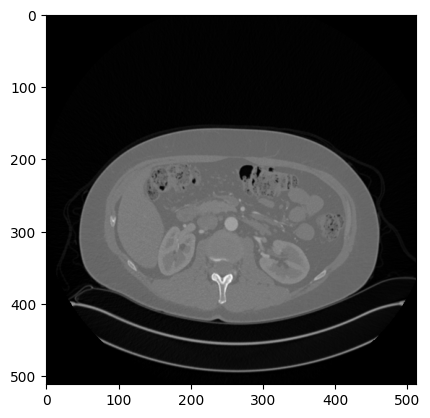

In [12]:
# Show image slice
imgSlice = img[200,:,:]
plt.imshow(imgSlice, cmap='gray')
plt.show()

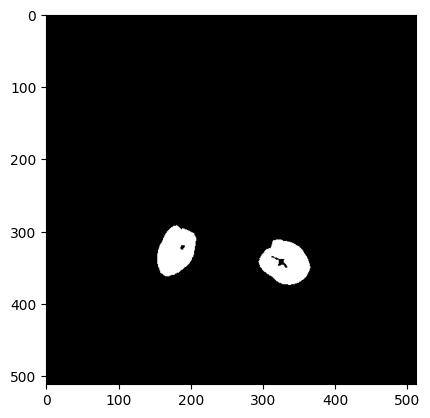

In [13]:
# Show image slice
imgSlice = mask[200,:,:]
plt.imshow(imgSlice, cmap='gray')
plt.show()

In [14]:
# Normalize image
def normalizeImageIntensityRange(img):
    img[img < HOUNSFIELD_MIN] = HOUNSFIELD_MIN
    img[img > HOUNSFIELD_MAX] = HOUNSFIELD_MAX
    return (img - HOUNSFIELD_MIN) / HOUNSFIELD_RANGE

nImg = normalizeImageIntensityRange(img)
np.min(nImg), np.max(nImg), nImg.shape, type(nImg)

(0.0, 0.8043333333333333, (611, 512, 512), numpy.ndarray)

In [15]:
# Read image or mask volume
def readImageVolume(imgPath, normalize=False):
    img = nib.load(imgPath).get_fdata()
    if normalize:
        return normalizeImageIntensityRange(img)
    else:
        return img

readImageVolume(imgPath, normalize=True)
readImageVolume(maskPath, normalize=False)

memmap([[[0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         ...,
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.]],

        [[0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         ...,
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.]],

        [[0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         ...,
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.]],

        ...,

        [[0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         ...,
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
    

In [16]:
# Save volume slice to file
def saveSlice(img, fname, path):
    img = np.uint8(img * 255)
    fout = os.path.join(path, f'{fname}.png')
    cv2.imwrite(fout, img)
    print(f'[+] Slice saved: {fout}', end='\r')


In [17]:
# Slice image in all directions and save
def sliceAndSaveVolumeImage(vol, fname, path):
    (dimx, dimy, dimz) = vol.shape
    print(dimx, dimy, dimz)
    cnt = 0
    if SLICE_X:
        cnt += dimx
        print('Slicing X: ')
        for i in range(dimx):
            saveSlice(vol[i,:,:], fname+f'-slice{str(i).zfill(SLICE_DECIMATE_IDENTIFIER)}_x', path)

    if SLICE_Y:
        cnt += dimy
        print('Slicing Y: ')
        for i in range(dimy):
            saveSlice(vol[:,i,:], fname+f'-slice{str(i).zfill(SLICE_DECIMATE_IDENTIFIER)}_y', path)

    if SLICE_Z:
        cnt += dimz
        print('Slicing Z: ')
        for i in range(dimz):
            saveSlice(vol[:,:,i], fname+f'-slice{str(i).zfill(SLICE_DECIMATE_IDENTIFIER)}_z', path)
    return cnt

In [18]:
for index, filename in enumerate(sorted(glob.iglob(imagePathInput+'*.nii'))):
    img = readImageVolume(filename, True)
    print(filename, img.shape, np.sum(img.shape), np.min(img), np.max(img))
    numOfSlices = sliceAndSaveVolumeImage(img, 'case'+str(index), imageSliceOutput)
    print(f'\n{filename}, {numOfSlices} slices created \n')

/content/Data/scan_images/case_00000.nii (611, 512, 512) 1635 0.0 0.8043333333333333
611 512 512
Slicing X: 
Slicing Y: 
[+] Slice saved: /content/drive/MyDrive/2-D/scan_images/case0-slice511_y.png
/content/Data/scan_images/case_00000.nii, 1123 slices created 

/content/Data/scan_images/case_00001.nii (602, 512, 512) 1626 0.0 0.7976666666666666
602 512 512
Slicing X: 
Slicing Y: 
[+] Slice saved: /content/drive/MyDrive/2-D/scan_images/case1-slice511_y.png
/content/Data/scan_images/case_00001.nii, 1114 slices created 

/content/Data/scan_images/case_00002.nii (261, 512, 512) 1285 0.0 1.0
261 512 512
Slicing X: 
Slicing Y: 
[+] Slice saved: /content/drive/MyDrive/2-D/scan_images/case2-slice511_y.png
/content/Data/scan_images/case_00002.nii, 773 slices created 

/content/Data/scan_images/case_00003.nii (270, 512, 512) 1294 0.0 1.0
270 512 512
Slicing X: 
Slicing Y: 
[+] Slice saved: /content/drive/MyDrive/2-D/scan_images/case3-slice511_y.png
/content/Data/scan_images/case_00003.nii, 782 s

In [19]:
# Read and process image mask volumes
for index, filename in enumerate(sorted(glob.iglob(maskPathInput+'*.nii'))):
    img = readImageVolume(filename, False)
    print(filename, img.shape, np.sum(img.shape), np.min(img), np.max(img))
    numOfSlices = sliceAndSaveVolumeImage(img, 'case'+str(index), maskSliceOutput)
    print(f'\n{filename}, {numOfSlices} slices created \n')

/content/Data/segmented_images/case_00000.nii (611, 512, 512) 1635 0.0 2.0
611 512 512
Slicing X: 
Slicing Y: 
[+] Slice saved: /content/drive/MyDrive/2-D/segmented_images/case0-slice511_y.png
/content/Data/segmented_images/case_00000.nii, 1123 slices created 

/content/Data/segmented_images/case_00001.nii (602, 512, 512) 1626 0.0 2.0
602 512 512
Slicing X: 
Slicing Y: 
[+] Slice saved: /content/drive/MyDrive/2-D/segmented_images/case1-slice511_y.png
/content/Data/segmented_images/case_00001.nii, 1114 slices created 

/content/Data/segmented_images/case_00002.nii (261, 512, 512) 1285 0.0 2.0
261 512 512
Slicing X: 
Slicing Y: 
[+] Slice saved: /content/drive/MyDrive/2-D/segmented_images/case2-slice511_y.png
/content/Data/segmented_images/case_00002.nii, 773 slices created 

/content/Data/segmented_images/case_00003.nii (270, 512, 512) 1294 0.0 2.0
270 512 512
Slicing X: 
Slicing Y: 
[+] Slice saved: /content/drive/MyDrive/2-D/segmented_images/case3-slice511_y.png
/content/Data/segmente

# MODEL

In [20]:
# Defining functions which will be used to create the model

def conv(x, filters, kernel_size=(3, 3), strides=1):
    '''
    This function will create the ConvBlock and return it
    Arguments:
    -----------------------------
    x - previous
    filters - value for the filters
    kernel_size - size of the kernels default value is (3,3)
    strides - size of the strids default value is 1
    ------------------------------
    '''

    conv = tensorflow.keras.layers.BatchNormalization()(x)
    conv = tensorflow.keras.layers.Activation('relu')(conv)
    conv = tensorflow.keras.layers.Conv2D(filters, kernel_size, padding='same', strides=strides)(conv)
    return conv

def res(x, filters, strides=1):
    '''
    This function will create the residual block and returns it.
    Arguments:
    ----------------------
    x - previous
    filters - size of the filters
    strides - size of the strides default value 1
    ----------------------
    '''

    r = conv(x, filters, kernel_size=(3, 3), strides=strides)
    r = conv(r, filters, kernel_size=(3, 3), strides=1)

    shortcut = tensorflow.keras.layers.Conv2D(filters, kernel_size=(1, 1), padding="same", strides=strides)(x)
    shortcut = tensorflow.keras.layers.BatchNormalization()(shortcut)

    output = tensorflow.keras.layers.Add()([shortcut, r])
    return output

In [21]:
def ResUNet():
    '''
    This function will create the ResUNet model and returns it.
    '''

    inputs = tensorflow.keras.layers.Input((256, 256, 3))
    enc0 = inputs
    c = tensorflow.keras.layers.Conv2D(16, (3, 3), padding="same", strides=1)(enc0)
    c2 = conv(c, 16, kernel_size=(3, 3), strides=1)
    s = tensorflow.keras.layers.Conv2D(16, kernel_size=(1, 1), padding="same", strides=1)(enc0)
    s2 = tensorflow.keras.layers.BatchNormalization()(s)

    enc1 = tensorflow.keras.layers.Add()([c2, s2])
    enc2 = res(enc1, 32, strides=2)
    enc3 = res(enc2, 64, strides=2)
    enc4 = res(enc3, 128, strides=2)
    enc5 = res(enc4, 256, strides=2)

    b0 = conv(enc5, 256, strides=1)
    b1 = conv(b0, 256, strides=1)

    upsamp1 = tensorflow.keras.layers.UpSampling2D((2, 2))(b1)
    upsamp1 = tensorflow.keras.layers.Concatenate()([upsamp1, enc4])
    dec1 = res(upsamp1, 256)

    upsamp2 = tensorflow.keras.layers.UpSampling2D((2, 2))(dec1)
    upsamp2 = tensorflow.keras.layers.Concatenate()([upsamp2, enc3])
    dec2 = res(upsamp2, 128)

    upsamp3 = tensorflow.keras.layers.UpSampling2D((2, 2))(dec2)
    upsamp3 = tensorflow.keras.layers.Concatenate()([upsamp3, enc2])
    dec3 = res(upsamp3, 64)

    upsamp4 = tensorflow.keras.layers.UpSampling2D((2, 2))(dec3)
    upsamp4 = tensorflow.keras.layers.Concatenate()([upsamp4, enc1])
    dec4 = res(upsamp4, 32)
    outputs = tensorflow.keras.layers.Conv2D(1, (1, 1), padding="same", activation="sigmoid")(dec4)
    model = tensorflow.keras.models.Model(inputs, outputs)
    return model


In [22]:
model = ResUNet()
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 256, 256, 16  448         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization (BatchNorm  (None, 256, 256, 16  64         ['conv2d[0][0]']                 
 alization)                     )                                                             

# Training

In [25]:
import numpy as np
from tensorflow.keras import backend as K

smooth = 1e-15
def dice_coef(y_true, y_pred):
    y_true = tf.keras.layers.Flatten()(y_true)
    y_pred = tf.keras.layers.Flatten()(y_pred)
    intersection = tf.reduce_sum(y_true * y_pred)
    return (2. * intersection + smooth) / (tf.reduce_sum(y_true) + tf.reduce_sum(y_pred) + smooth)

def dice_loss(y_true, y_pred):
    return 1.0 - dice_coef(y_true, y_pred)

In [60]:
from sklearn.utils import shuffle
import tensorflow as tf
from tensorflow.keras.callbacks import ModelCheckpoint, CSVLogger, ReduceLROnPlateau, EarlyStopping, TensorBoard
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import train_test_split

""" Global parameters """
H = 256
W = 256

def create_dir(path):
    if not os.path.exists(path):
        os.makedirs(path)

def load_dataset(path, split=0.25):
    images = sorted(glob(os.path.join(path, "scan_images", "*.png")))
    masks = sorted(glob(os.path.join(path, "segmented_images", "*.png")))

    split_size = int(len(images) * split)

    train_x, valid_x = train_test_split(images, test_size=split_size, random_state=42)
    train_y, valid_y = train_test_split(masks, test_size=split_size, random_state=42)

    train_x, test_x = train_test_split(train_x, test_size=split_size, random_state=42)
    train_y, test_y = train_test_split(train_y, test_size=split_size, random_state=42)

    return (train_x, train_y), (valid_x, valid_y), (test_x, test_y)


In [50]:
def read_image(path):
    path = path.decode()
    x = cv2.imread(path, cv2.IMREAD_COLOR)
    x = cv2.resize(x, (W, H))
    x = x / 255.0
    x = x.astype(np.float32)
    return x

def read_mask(path):
    path = path.decode()
    x = cv2.imread(path, cv2.IMREAD_GRAYSCALE)  ## (h, w)
    x = cv2.resize(x, (W, H))   ## (h, w)
    x = x / 255.0               ## (h, w)
    x = x.astype(np.float32)    ## (h, w)
    x = np.expand_dims(x, axis=-1)## (h, w, 1)
    return x

def tf_parse(x, y):
    def _parse(x, y):
        x = read_image(x)
        y = read_mask(y)
        return x, y

    x, y = tf.numpy_function(_parse, [x, y], [tf.float32, tf.float32])
    x.set_shape([H, W, 3])
    y.set_shape([H, W, 1])
    return x, y

def tf_dataset(X, Y, batch=2):
    dataset = tf.data.Dataset.from_tensor_slices((X, Y))
    dataset = dataset.map(tf_parse)
    dataset = dataset.batch(batch)
    dataset = dataset.prefetch(10)
    return dataset


In [51]:
""" Seeding """
np.random.seed(42)
tf.random.set_seed(42)

In [52]:
""" Directory for storing files """
create_dir("/content/drive/MyDrive/model/")


In [58]:
""" Hyperparameters """
batch_size = 8
lr = 1e-4
num_epochs = 30
model_path = os.path.join("/content/drive/MyDrive/model/", "model2.h5")
csv_path = os.path.join("/content/drive/MyDrive/model/", "log2.csv")

In [90]:
""" Dataset """
dataset_path = "/content/drive/MyDrive/2-D/"
(train_x, train_y), (valid_x, valid_y), (test_x, test_y) = load_dataset(dataset_path)

print(f"Train: {len(train_x)} - {len(train_y)}")
print(f"Valid: {len(valid_x)} - {len(valid_y)}")
print(f"Test : {len(test_x)} - {len(test_y)}")

train_dataset = tf_dataset(train_x, train_y, batch=batch_size)
valid_dataset = tf_dataset(valid_x, valid_y, batch=batch_size)

Train: 7378 - 7378
Valid: 3688 - 3688
Test : 3688 - 3688


In [62]:
model = ResUNet()
model.compile(loss=dice_loss, optimizer=Adam(lr), metrics=[dice_coef,"binary_accuracy"])


In [63]:
callbacks = [
        ModelCheckpoint(model_path, verbose=1, save_best_only=True),
        ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=5, min_lr=1e-7, verbose=1),
        CSVLogger(csv_path),
        EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=False),
    ]

In [64]:
model.fit(
        train_dataset,
        epochs = 10,
        validation_data=valid_dataset,
        callbacks=callbacks
    )

Epoch 1/10
923/923 [==============================] - ETA: 0s - loss: 0.4467 - dice_coef: 0.5529 - binary_accuracy: 0.9844
Epoch 1: val_loss improved from inf to 0.42006, saving model to /content/drive/MyDrive/model/model2.h5
923/923 [==============================] - 270s 269ms/step - loss: 0.4467 - dice_coef: 0.5529 - binary_accuracy: 0.9844 - val_loss: 0.4201 - val_dice_coef: 0.5799 - val_binary_accuracy: 0.9953 - lr: 1.0000e-04
Epoch 2/10
923/923 [==============================] - ETA: 0s - loss: 0.2364 - dice_coef: 0.7630 - binary_accuracy: 0.9966
Epoch 2: val_loss improved from 0.42006 to 0.23231, saving model to /content/drive/MyDrive/model/model2.h5
923/923 [==============================] - 238s 258ms/step - loss: 0.2364 - dice_coef: 0.7630 - binary_accuracy: 0.9966 - val_loss: 0.2323 - val_dice_coef: 0.7677 - val_binary_accuracy: 0.9972 - lr: 1.0000e-04
Epoch 3/10
923/923 [==============================] - ETA: 0s - loss: 0.1930 - dice_coef: 0.8063 - binary_accuracy: 0.9971
E

# Visulization

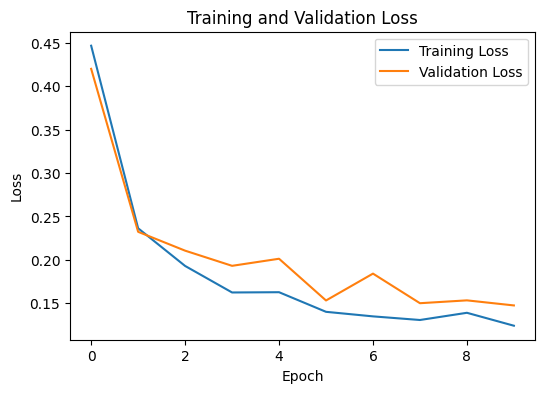

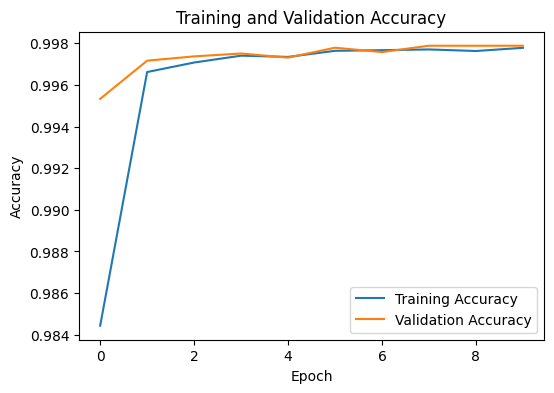

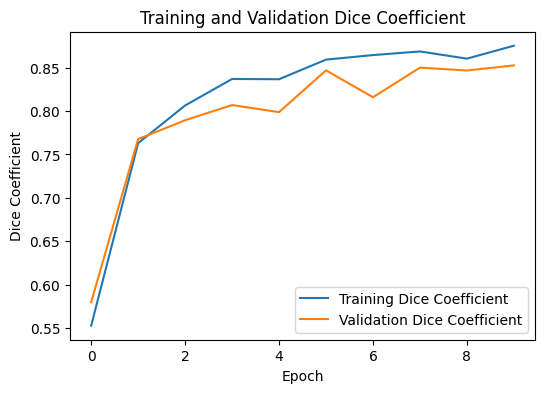

In [85]:

# Read the CSV file
data = pd.read_csv("/content/drive/MyDrive/model/log2.csv")

# Extract the required columns
epoch = data['epoch']
train_loss = data['loss']
train_accuracy = data['binary_accuracy']
train_dice_coef = data['dice_coef']
val_loss = data['val_loss']
val_accuracy = data['val_binary_accuracy']
val_dice_coef = data['val_dice_coef']

# Plot the training and validation loss
plt.figure(figsize=(6, 4))
plt.plot(epoch, train_loss, label='Training Loss')
plt.plot(epoch, val_loss, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

def display_results(original_image, mask_image, predicted_mask):
    fig, axes = plt.subplots(1, 3, figsize=(12, 4))

    axes[0].imshow(original_image, cmap='gray')
plt.legend()
plt.show()

# Plot the training and validation accuracy
plt.figure(figsize=(6, 4))
plt.plot(epoch, train_accuracy, label='Training Accuracy')
plt.plot(epoch, val_accuracy, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()
plt.show()

# Plot the training and validation dice coefficient
plt.figure(figsize=(6, 4))
plt.plot(epoch, train_dice_coef, label='Training Dice Coefficient')
plt.plot(epoch, val_dice_coef, label='Validation Dice Coefficient')
plt.xlabel('Epoch')
plt.ylabel('Dice Coefficient')
plt.title('Training and Validation Dice Coefficient')
plt.legend()
plt.show()


# Testing

In [91]:
from glob import glob
from tqdm import tqdm
from tensorflow.keras.utils import CustomObjectScope
from sklearn.metrics import f1_score, jaccard_score, precision_score, recall_score
from sklearn.model_selection import train_test_split

In [72]:
def save_results(image, mask, y_pred, save_image_path):
    mask = np.expand_dims(mask, axis=-1)
    mask = np.concatenate([mask, mask, mask], axis=-1)

    y_pred = np.expand_dims(y_pred, axis=-1)
    y_pred = np.concatenate([y_pred, y_pred, y_pred], axis=-1)
    y_pred = y_pred * 255

    line = np.ones((image.shape[0], 10, 3)) * 255

    cat_images = np.concatenate([image, line, mask, line, y_pred], axis=1)
    cv2.imwrite(save_image_path, cat_images)

    # Convert the image to 8-bit depth
    cat_images_8bit = np.uint8(cat_images)

    # Display the image using Matplotlib
    plt.imshow(cv2.cvtColor(cat_images_8bit, cv2.COLOR_BGR2RGB))
    plt.axis('off')
    plt.show()

In [69]:
""" Load the model """
with CustomObjectScope({"dice_coef": dice_coef, "dice_loss": dice_loss}):
    model = tf.keras.models.load_model(os.path.join("/content/drive/MyDrive/model/", "model.h5"))

In [92]:
len(test_y)

3688

# Visualzation of real image, masked image and predicted mask image

In [ ]:
SCORE = []
for x, y in tqdm(zip(test_x, test_y), total=len(test_y)):
    """ Extracting the name """
    name = x.split("/")[-1]
    """ Reading the image """
    image = cv2.imread(x, cv2.IMREAD_COLOR) ## [H, w, 3]
    image = cv2.resize(image, (W, H))       ## [H, w, 3]
    x = image/255.0                         ## [H, w, 3]
    x = np.expand_dims(x, axis=0)           ## [1, H, w, 3]
    """ Reading the mask """
    mask = cv2.imread(y, cv2.IMREAD_GRAYSCALE)
    mask = cv2.resize(mask, (W, H))
    """ Prediction """
    y_pred = model.predict(x, verbose=0)[0]
    y_pred = np.squeeze(y_pred, axis=-1)
    y_pred = y_pred >= 0.5
    y_pred = y_pred.astype(np.int32)
    """ Saving the prediction """
    save_image_path = os.path.join("results", name)
    save_results(image, mask, y_pred, save_image_path)
    """ Flatten the array """
    mask = mask/255.0
    mask = (mask > 0.5).astype(np.int32).flatten()
    y_pred = y_pred.flatten()
    """ Calculating the metrics values """
    f1_value = f1_score(mask, y_pred, labels=[0, 1], average="binary")
    jac_value = jaccard_score(mask, y_pred, labels=[0, 1], average="binary")
    recall_value = recall_score(mask, y_pred, labels=[0, 1], average="binary", zero_division=0)
    precision_value = precision_score(mask, y_pred, labels=[0, 1], average="binary", zero_division=0)
    if f1_value != 0 and jac_value != 0 and recall_value != 0 and precision_value != 0:
       SCORE.append([name, f1_value, jac_value, recall_value, precision_value])

# Test metrices

In [97]:
score = [s[1:]for s in SCORE]
score = np.mean(score, axis=0)
print(f"F1: {score[0]:0.5f}")
print(f"Jaccard: {score[1]:0.5f}")
print(f"Recall: {score[2]:0.5f}")
print(f"Precision: {score[3]:0.5f}")
df = pd.DataFrame(SCORE, columns=["Image", "F1", "Jaccard", "Recall", "Precision"])
df.to_csv("/content/drive/MyDrive/model/score.csv")

F1: 0.94210
Jaccard: 0.89860
Recall: 0.95204
Precision: 0.94205
